In [1]:
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tqdm import tqdm
from math import log10
from sklearn import preprocessing
from sklearn import metrics

In [4]:
df = pd.read_csv('wbdc.csv')
df = df.iloc[:, 1:]

In [5]:
df.iloc[:, 0] = df.iloc[:, 0].replace({'M' : 1, 'B' : 0})

In [6]:
df.head()

,Diagnosis,Mean Radius,Mean Texture,Mean Perimeter,Mean Area,Mean Smoothness,Mean Compactness,Mean Concavity,Mean Concave,Mean Symmetry,...,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Compactness,Worst Concavity,Worst Concave,Worst Symmetry,Worst Fractal
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


FUNCTIONS NEEDED

In [7]:
def train_test_df(df):
    df = shuffle(df) 
    
    M_df = df[df['Diagnosis']==1]
    B_df = df[df['Diagnosis']==0]
    
    M_test = M_df.iloc[:int(0.20*len(M_df)), :]
    M_train = M_df.iloc[int(0.20*len(M_df)):, :]
    
    B_test = B_df.iloc[:int(0.20*len(B_df)), :]
    B_train = B_df.iloc[int(0.20*len(B_df)):, :]
    
    train_df = pd.concat([M_train, B_train])
    test_df = pd.concat([M_test, B_test])
    x_train = train_df.iloc[:, 1:]
    y_train = train_df.iloc[:, 0]
    x_test = test_df.iloc[:, 1:]
    y_test = test_df.iloc[:, 0]
    return x_train, y_train, x_test, y_test

In [8]:
def roc_curve(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc_ = metrics.auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.plot(fpr, tpr, label=' (area = {:.3f})'.format(auc_))
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [9]:
def get_c_range(x_train, y_train):
    c_ = np.logspace(-5, 8, 10)
    scores = []
    for c in c_:
        svc = LinearSVC(penalty='l1', C=c, dual=False)
        svc.fit(x_train, y_train)
        scores.append(svc.score(x_train, y_train))
    scores = np.array(scores)
    ind = np.argwhere(scores > 0.9).flatten()
    c_1 = c_[ind[0]]
    c_2 = c_[ind[-1]]
    return c_1, c_2

In [10]:
def return_results(results):
    print('Avg. Train Accuracy {}'.format(np.mean(results.iloc[:, 0])))
    print('Avg. Train Precision {}'.format(np.mean(results.iloc[:, 1])))
    print('Avg. Train Recall {}'.format(np.mean(results.iloc[:, 2])))
    print('Avg. Train F-1 score {}'.format(np.mean(results.iloc[:, 3])))
    print('Avg. Train AUC {}'.format(np.mean(results.iloc[:, 4])))

    print('\nTest Accuracy {}'.format(np.mean(results.iloc[:, 5])))
    print('Test Precision {}'.format(np.mean(results.iloc[:, 6])))
    print('Test Recall {}'.format(np.mean(results.iloc[:, 7])))
    print('Test F1 Score {}'.format(np.mean(results.iloc[:, 8])))
    print('Test AUC {}'.format(np.mean(results.iloc[:, 9])))

In [11]:
def linearSVC(x_train, y_train, scoring):
    c_l, c_h = get_c_range(x_train, y_train)
    parameters = {'C':np.logspace(log10(c_l), log10(c_h), 20)}

    svc = LinearSVC(penalty='l1', dual=False)
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    clf = GridSearchCV(svc, parameters, cv=kf, scoring=scoring, refit='roc_auc', return_train_score=True)
    clf.fit(x_train, y_train)
    return clf.best_estimator_, clf.cv_results_

i. Supervised Learning: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [03:19<00:06,  6.25s/it]


For Run Number 29
Train Confusion Matrix
[[282   4]
 [  6 164]]


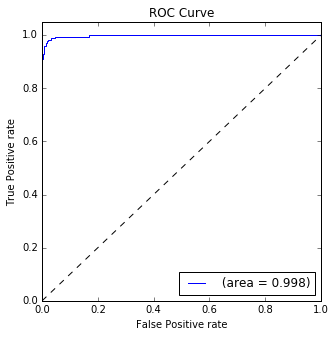


Test Confusion Matrix
[[64  7]
 [ 2 40]]


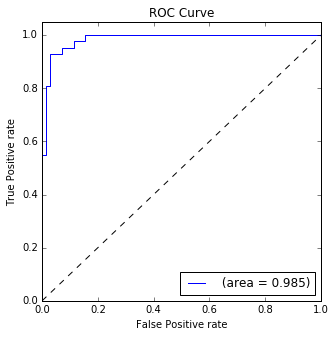

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:26<00:00,  6.40s/it]


Avg. Train Accuracy 0.9646666666666666
Avg. Train Precision 0.9706666666666665
Avg. Train Recall 0.9336666666666668
Avg. Train F-1 score 0.9513333333333331
Avg. Train AUC 0.9899999999999997

Test Accuracy 0.9566666666666668
Test Precision 0.9383333333333332
Test Recall 0.9463333333333334
Test F1 Score 0.9413333333333332
Test AUC 0.9540000000000001


In [13]:
#Use normalized data. Report the average accuracy, precision, recall, F-score, and AUC, for both training and test sets 
#over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.
results1 = []

for i in tqdm(range(30)):
    #print('Run Number {}'.format(i))
    each = []
    x_train, y_train, x_test, y_test = train_test_df(df)
    scaler = preprocessing.Normalizer()
    x_train_ = scaler.fit_transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    sv, results = linearSVC(x_train_, y_train, scoring)
    
    each.append(round(np.mean(results['mean_train_accuracy']), 2))
    each.append(round(np.mean(results['mean_train_precision']), 2))
    each.append(round(np.mean(results['mean_train_recall']), 2))
    each.append(round(np.mean(results['mean_train_f1']), 2))
    each.append(round(np.mean(results['mean_train_roc_auc']), 2))
    
    # calculating test accuracy
    y_pred = sv.predict(x_test_)
    
    each.append(round(metrics.accuracy_score(y_test, y_pred), 2))
    each.append(round(metrics.recall_score(y_test, y_pred), 2))
    each.append(round(metrics.precision_score(y_test, y_pred), 2))
    each.append(round(metrics.f1_score(y_test, y_pred), 2))
    each.append(round(metrics.roc_auc_score(y_test, y_pred), 2))
    
    #print('Avg. Train Accuracy {}'.format(round(np.mean(results['mean_train_accuracy']), 2)))
    #print('Test Accuracy {}'.format(round(metrics.accuracy_score(y_test, y_pred), 2)))
    
    if(i == 29):
        print('\nFor Run Number {}'.format(i))
        kf = StratifiedKFold(n_splits=5, shuffle=True)
        calib = CalibratedClassifierCV(sv, cv=kf)
        
        cnf_train = metrics.confusion_matrix(y_train, sv.predict(x_train_))
        print('Train Confusion Matrix')
        print(cnf_train)
        calib.fit(x_train_, y_train)
        roc_curve(calib, x_train_, y_train)

        cnf_test = metrics.confusion_matrix(y_test, y_pred)
        print('\nTest Confusion Matrix')
        print(cnf_test)
        roc_curve(calib, x_test_, y_test)
    results1.append(each)

pd.DataFrame(results1).to_csv('results11.csv', index=False)
return_results(pd.DataFrame(results1))

ii. Semi-Supervised Learning/ Self-training: select 50% of the positive
class along with 50% of the negative class in the training set as labeled data
and the rest as unlabelled data. You can select them randomly.   
   
A. Train an L1-penalized SVM to classify the labeled data Use normalized
data. Choose the penalty parameter using 5 fold cross validation.   
   
B. Find the unlabeled data point that is the farthest to the decision boundary
of the SVM. Let the SVM label it (ignore its true label), and add it to
the labeled data, and retrain the SVM. Continue this process until all
unlabeled data are used. Test the final SVM on the test data andthe
average accuracy, precision, recall, F-score, and AUC, for both training
and test sets over your M runs. Plot the ROC and report the confusion
matrix for training and testing in one of the runs.

In [14]:
def train_test_split_df(df):
    df = shuffle(df) 
    M_df = df[df['Diagnosis']==1]
    B_df = df[df['Diagnosis']==0]
    
    M_test = M_df.iloc[:int(0.20*len(M_df)), :]
    M_train = M_df.iloc[int(0.20*len(M_df)):, :]
    
    B_test = B_df.iloc[:int(0.20*len(B_df)), :]
    B_train = B_df.iloc[int(0.20*len(B_df)):, :]
    
    train_df = pd.concat([M_train, B_train])
    test_df = pd.concat([M_test, B_test])
    return train_df, test_df

In [15]:
def lab_unlab_split(df):
    df = shuffle(df) 
    M_df = df[df['Diagnosis']==1]
    B_df = df[df['Diagnosis']==0]
    
    M_test = M_df.iloc[:int(0.50*len(M_df)), :]
    M_train = M_df.iloc[int(0.50*len(M_df)):, :]
    
    B_test = B_df.iloc[:int(0.50*len(B_df)), :]
    B_train = B_df.iloc[int(0.50*len(B_df)):, :]
    
    train_df = pd.concat([M_train, B_train])
    test_df = pd.concat([M_test, B_test])
    x_train = train_df.iloc[:, :-1]
    y_train = train_df.iloc[:, -1]
    x_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]
    
    return x_train, y_train, x_test, y_test

In [16]:
x_cols = df.columns.values[1:]
y_cols = df.columns.values[0]

In [17]:
def get_farthest_points(svc, x_test_):
    dd = pd.DataFrame(x_test_)
    dist = svc.decision_function(x_test_)
    #w_norm = np.linalg.norm(svc.coef_)
    #dist = y / w_norm
    d = np.argmax(dist)
    point = svc.predict([dd.iloc[d, :]])
    
    return d, dd.iloc[d,:], point

In [ ]:
#Use normalized data. Report the average accuracy, precision, recall, F-score, and AUC, for both training and test sets 
#over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.
results2 = []

for i in tqdm(range(30)):
    #print('Run Number {}'.format(i))
    each = []
    
    #Divide the initial df into 80-20 test-train
    train_d, test_d = train_test_split_df(df)
    
    x_train_ = train_d.iloc[:, 1:]
    y_train = train_d.iloc[:, 0]
    x_test_ = test_d.iloc[:, 1:]
    y_test = test_d.iloc[:, 0]
    
    scaler = preprocessing.Normalizer()
    
    train_data = pd.DataFrame(scaler.fit_transform(x_train_), columns=df.columns.values[1:])
    test_data = pd.DataFrame(scaler.transform(x_test_), columns=df.columns.values[1:])
    
    train_data['Diagnosis'] = [int(i) for i in y_train]
    test_data['Diagnosis'] = [int(j) for j in y_test]
    
    #print(df.shape, train_data.shape, test_data.shape)
    
    #Concat train data, and divide into 50-50 labelled and unlabelled
    #train_data = pd.concat([x_train, y_train])
    lab_x, lab_y, unlab_x, unlab_y = lab_unlab_split(train_data)
    times = len(unlab_x) + 1
    
    for j in range(times):
        #Use labelled data as your training data and unlabelled data as your test data
        #print(lab_x.shape, lab_y.shape, unlab_x.shape, unlab_y.shape)
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        sv, results = linearSVC(lab_x, lab_y, scoring)
        
        if(j < (times-1)):
            d, xx, yy = get_farthest_points(sv, unlab_x)
            lab_x = lab_x.append(pd.Series(xx))
            lab_y = lab_y.append(pd.Series(yy))
            unlab_x.drop(unlab_x.index[d], inplace=True)
            unlab_y.drop(unlab_y.index[d], inplace=True)

    each.append(round(np.mean(results['mean_train_accuracy']), 2))
    each.append(round(np.mean(results['mean_train_precision']), 2))
    each.append(round(np.mean(results['mean_train_recall']), 2))
    each.append(round(np.mean(results['mean_train_f1']), 2))
    each.append(round(np.mean(results['mean_train_roc_auc']), 2))
    
    # calculating test accuracy
    x_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]
    y_pred = sv.predict(x_test)
    
    each.append(round(metrics.accuracy_score(y_test, y_pred), 2))
    each.append(round(metrics.recall_score(y_test, y_pred), 2))
    each.append(round(metrics.precision_score(y_test, y_pred), 2))
    each.append(round(metrics.f1_score(y_test, y_pred), 2))
    each.append(round(metrics.roc_auc_score(y_test, y_pred), 2))
    
    #print('Avg. Train Accuracy {}'.format(round(np.mean(results['mean_train_accuracy']), 2)))
    #print('Test Accuracy {}'.format(round(metrics.accuracy_score(y_test, y_pred), 2)))
    
    if(i == 29):
        print('\nFor Run Number {}'.format(i))
        kf = StratifiedKFold(n_splits=5, shuffle=True)
        calib = CalibratedClassifierCV(sv, cv=kf)
        
        cnf_train = metrics.confusion_matrix(y_train, sv.predict(x_train))
        print('Train Confusion Matrix')
        print(cnf_train)
        calib.fit(lab_x, lab_y)
        roc_curve(calib, lab_x, lab_y)

        cnf_test = metrics.confusion_matrix(y_test, y_pred)
        print('\nTest Confusion Matrix')
        print(cnf_test)
        roc_curve(calib, x_test, y_test)
    
    results2.append(each)
    #print('\n')

pd.DataFrame(results2).to_csv('results12.csv', index=False)
return_results(pd.DataFrame(results2))


 47%|███████████████████████████████████▍                                        | 14/30 [5:10:07<6:03:49, 1364.35s/it]

iii. Unsupervised Learning: Run k-means algorithm on the whole training
set. Ignore the labels of the data, and assume k = 2.   
   
A. Run the k-means algorithm multiple times. Make sure that you initialize
the algoritm randomly. How do you make sure that the algorithm was
not trapped in a local minimum?   
   
B. Compute the centers of the two clusters and find the closest 30 data
points to each center. Read the true labels of those 30 data points and
take a majority poll within them. The majority poll becomes the label
predicted by k-means for the members of each cluster. Then compare the
labels provided by k-means with the true labels of the training data and
report the average accuracy, precision, recall, F-score, and AUC over M
runs, and ROC and the confusion matrix for one of the runs.   
   
C. Classify test data based on their proximity to the centers of the clusters.
Report the average accuracy, precision, recall, F-score, and AUC over M
runs, and ROC and the confusion matrix for one of the runs for the test
data.

With the k-means algorithm, you cannot entirely avoid local minima; you can only try to minimize your chances of getting one.

A common hack used by many, and the one that can be done is setting n_init = 100 is to run K-means multiple times and then choosing the run that gives the lowest error. If you run this k^n times and then choose the best out of that, then you WOULD be guaranteed you're finding a global minima, but that's too time consuming to be practical.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def kmeans_transform(kmeans, train_data):
    k = kmeans.fit_transform(train_data)
    res1 = []
    res2 = []

    for i in range(len(k)):
        each = k[i]
        which = np.argmin(each)
        if(which==0): res1.append([i, 'cluster1', each[0]])
        else: res2.append([i, 'cluster2', each[1]])
    
    top_cluster1 = pd.DataFrame(res1).sort_values([2], ascending=True)[:30].iloc[:, 0].reset_index(drop=True)
    top_cluster2 = pd.DataFrame(res2).sort_values([2], ascending=True)[:30].iloc[:, 0].reset_index(drop=True)
    
    major_cluster = {'cluster1': {'0':0, '1':0}, 'cluster2': {'0':0, '1':0}}
    for p in top_cluster1:
        if(y_train[p] == 0):
            major_cluster['cluster1']['0'] += 1
        else:
            major_cluster['cluster1']['1'] += 1

    for q in top_cluster2:
        if(y_train[q] == 0):
            major_cluster['cluster2']['0'] += 1
        else:
            major_cluster['cluster2']['1'] += 1
            
    print(major_cluster)
    clust1 = 0 if major_cluster['cluster1']['0'] > major_cluster['cluster1']['1'] else 1
    clust2 = 0 if major_cluster['cluster2']['0'] > major_cluster['cluster2']['1'] else 1
    
    return clust1, clust2

In [ ]:
def give_scores(y_train, y_pred, y_test, y_pred_test):
    each = []
    each.append(round(metrics.accuracy_score(y_train, y_pred), 2))
    each.append(round(metrics.recall_score(y_train, y_pred), 2))
    each.append(round(metrics.precision_score(y_train, y_pred), 2))
    each.append(round(metrics.f1_score(y_train, y_pred), 2))
    each.append(round(metrics.roc_auc_score(y_train, y_pred), 2))

    each.append(round(metrics.accuracy_score(y_test, y_pred_test), 2))
    each.append(round(metrics.recall_score(y_test, y_pred_test), 2))
    each.append(round(metrics.precision_score(y_test, y_pred_test), 2))
    each.append(round(metrics.f1_score(y_test, y_pred_test), 2))
    each.append(round(metrics.roc_auc_score(y_test, y_pred_test), 2))

    return each

In [ ]:
# report the average accuracy, precision, recall, F-score, and AUC over M runs, 
#and ROC and the confusion matrix for one of the runs.
results3 = []

for i in tqdm(range(30)):
    #Divide the initial df into 80-20 test-train
    train_d, test_d = train_test_split_df(df)
    
    x_train_ = train_d.iloc[:, 1:].reset_index(drop=True)
    y_train = train_d.iloc[:, 0].reset_index(drop=True)
    x_test_ = test_d.iloc[:, 1:].reset_index(drop=True)
    y_test = test_d.iloc[:, 0].reset_index(drop=True)

    #scaler = preprocessing.Normalizer()

    #train_data = pd.DataFrame(scaler.fit_transform(x_train_), columns=df.columns.values[1:])
    #test_data = pd.DataFrame(scaler.fit_transform(x_test_), columns=df.columns.values[1:])
    
    train_data = x_train_
    test_data = x_test_
    
    #Initiate the model
    kmeans = KMeans(n_clusters=2, init='random', n_init=100)
    kmeans.fit(train_data)
    
    clust1, clust2 = kmeans_transform(kmeans, train_data)
    y_pred = pd.DataFrame(kmeans.predict(train_data)).replace({0:clust1, 1:clust2})
    y_pred_test = pd.DataFrame(kmeans.predict(test_data)).replace({0:clust1, 1:clust2})
    results3.append(give_scores(y_train, y_pred, y_test, y_pred_test))
    
    if(i == 29):
        print('For Run Number {}'.format(i))
        #kf = StratifiedKFold(n_splits=5, shuffle=True)
        #calib = CalibratedClassifierCV(kmeans, cv=kf)
        #calib.fit(train_data, y_train)
        
        cnf_train = metrics.confusion_matrix(y_train, y_pred)
        print('Train Confusion Matrix')
        print(cnf_train)
        #roc_curve(calib, train_data, y_train)

        cnf_test = metrics.confusion_matrix(y_test, y_pred_test)
        print('\nTest Confusion Matrix')
        print(cnf_test)
        #roc_curve(calib, test_data, y_test)

pd.DataFrame(results3).to_csv('results13.csv', index=False)
return_results(pd.DataFrame(results3))

iv. Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Research what spectral clustering is. Use RBF
kernel.

In [ ]:
#Invoke a Spectral Embedding and then Run a different KMeans model on it

In [ ]:
from sklearn.manifold import SpectralEmbedding

In [ ]:
# report the average accuracy, precision, recall, F-score, and AUC over M runs, 
#and ROC and the confusion matrix for one of the runs.
results4 = []

for i in tqdm(range(30)):
    #Divide the initial df into 80-20 test-train
    train_d, test_d = train_test_split_df(df)
    
    x_train_ = train_d.iloc[:, 1:].reset_index(drop=True)
    y_train = train_d.iloc[:, 0].reset_index(drop=True)
    x_test_ = test_d.iloc[:, 1:].reset_index(drop=True)
    y_test = test_d.iloc[:, 0].reset_index(drop=True)
    
    #Invoking a Spectral Embedding and then invoking a new KMeans model with it
    embed = SpectralEmbedding(n_components=30, affinity='rbf')
    train_data = embed.fit_transform(x_train_)
    test_data = embed.fit_transform(x_test_)
    
    #Initiate the model
    kmeans = KMeans(n_clusters=2, init='random', n_init=100)
    kmeans.fit(train_data)
    
    clust1, clust2 = kmeans_transform(kmeans, train_data)
    y_pred = pd.DataFrame(kmeans.predict(train_data)).replace({0:clust1, 1:clust2})
    y_pred_test = pd.DataFrame(kmeans.predict(test_data)).replace({0:clust1, 1:clust2})
    results4.append(give_scores(y_train, y_pred, y_test, y_pred_test))
    
    if(i == 29):
        print('For Run Number {}'.format(i))
        #kf = StratifiedKFold(n_splits=5, shuffle=True)
        #calib = CalibratedClassifierCV(kmeans, cv=kf)
        #calib.fit(train_data, y_train)
        
        cnf_train = metrics.confusion_matrix(y_train, y_pred)
        print('Train Confusion Matrix')
        print(cnf_train)
        #roc_curve(calib, train_data, y_train)

        cnf_test = metrics.confusion_matrix(y_test, y_pred_test)
        print('\nTest Confusion Matrix')
        print(cnf_test)
        #roc_curve(calib, test_data, y_test)

pd.DataFrame(results4).to_csv('results14.csv', index=False)
return_results(pd.DataFrame(results4))

2. Active Learning Using Support Vector Machines   
   
(a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points ran-
domly as the test set, and the remaining 900 points as the training set. This is a
binary classification problem.

(b) Repeat each of the following two procedures 50 times. You will have 50 errors for
90 SVMs per each procedure.   
   
i. Train a SVM with a pool of 10 randomly selected data points from the training
set using linear kernel and L1 penalty. Select the penalty parameter using
10-fold cross validation.2 Repeat this process by adding 10 other randomly
selected data points to the pool, until you use all the 900 points. Do NOT
replace the samples back into the training set at each step. Calculate the
test error for each SVM. You will have 90 SVMs that were trained using 10,
20, 30, ... , 900 data points and their 90 test errors. You have implemented
passive learning.   

ii. Train a SVM with a pool of 10 randomly selected data points from the training
set3 using linear kernel and L1 penalty. Select the parameters of the SVM
with 10-fold cross validation. Choose the 10 closest data points in the training
set to the hyperplane of the SVM4 and add them to the pool. Do not replace
the samples back into the training set. Train a new SVM using the pool.
Repeat this process until all training data is used. You will have 90 SVMs
that were trained using 10, 20, 30,..., 900 data points and their 90 test errors.
You have implemented active learning.

(c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i
and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot
average test error versus number of training instances for both active and passive
learners on the same figure and report your conclusions. Here, you are actually
obtaining a learning curve by Monte-Carlo simulation.